In [69]:
import pickle
import numpy as np
import pandas as pd

import pystan

%matplotlib inline


In [53]:
stan_model = """
data {
    // Define input data in this block
    int n;  // Number of samples
    int m;  // Number of features
    matrix[n, m] features;
    vector[n] y;  // outcome
}
transformed data {
    // Modify / transform input data
    // This block runs once.
}
parameters {
    // These are random parameters which we
    // want to estimate
    vector[m] beta;  // Coefficients
    real<lower=0> epsilon;  // Uncertainty / unexplained variance
}
transformed parameters {
    // Create quantities derived from the parameters.
    // Runs on every evaluation of log-prob
}
model {
    // Define your model here
    y ~ normal(features * beta, epsilon);
        
    // Equivalent to:
    // increment_log_prob(normal_log(y, features * beta, epsilon));
}
generated quantities {
    // Can use to simulate / predict using parameters
    // Runs once per MCMC step after warmup
}
"""

In [17]:
# Generate some data for us to fit
rng = np.random.RandomState(42)
n_samples = 10
n_feat = 4

feat = rng.normal(0, 1, size=(n_samples, n_feat))
tgt = feat @ np.array([-1, 0.4, 0, 0]) + rng.normal(scale=0.2, size=n_samples)

In [54]:
lin_reg = pystan.model.StanModel(model_code=stan_model,
                                 model_name='linear_regression')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL linear_regression_60735e122f0a965601a23bea56dd6984 NOW.
/usr/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpke8b_a1d/stanfit4linear_regression_60735e122f0a965601a23bea56dd6984_3651703397766875329.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [56]:
lin_fit = lin_reg.sampling(data={'n': n_samples, 
                                 'm': n_feat, 
                                 'features': feat, 
                                 'y': tgt}, 
                           iter=1000, chains=4, 
                           warmup=500, n_jobs=-1,
                           seed=42)

In [57]:
lin_fit

Inference for Stan model: linear_regression_60735e122f0a965601a23bea56dd6984.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]  -0.99  3.4e-3   0.11  -1.23  -1.06  -0.99  -0.92  -0.77   1121    1.0
beta[2]   0.43  2.4e-3   0.08   0.26   0.38   0.43   0.47   0.58   1232    1.0
beta[3]   0.07  2.6e-3   0.07  -0.08   0.03   0.07   0.11   0.22    791    1.0
beta[4]   0.08  1.5e-3   0.06  -0.03   0.04   0.08   0.11    0.2   1633    1.0
epsilon    0.2  4.0e-3   0.09    0.1   0.14   0.18   0.23    0.4    520   1.01
lp__     10.65    0.12    2.3   4.94   9.62  11.14  12.29  13.53    348   1.02

Samples were drawn using NUTS at Sun Oct 28 12:36:33 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [58]:
chains = lin_fit.extract()

In [59]:
chains

OrderedDict([('beta',
              array([[-0.83226295,  0.41688744,  0.12780694,  0.04432454],
                     [-1.03552887,  0.52963223,  0.04891922,  0.10108938],
                     [-1.06812784,  0.43503511,  0.07158374,  0.07847875],
                     ...,
                     [-0.97482989,  0.45956014,  0.01832845,  0.09522064],
                     [-1.1402297 ,  0.33865971,  0.10125783,  0.09755542],
                     [-0.94878411,  0.34678997, -0.04515089,  0.00732525]])),
             ('epsilon',
              array([0.18307015, 0.11994982, 0.18668653, ..., 0.1043261 , 0.123147  ,
                     0.24788388])),
             ('lp__',
              array([10.14992779,  9.78694805, 12.63445417, ..., 12.70367702,
                     10.47375492,  8.20959273]))])

In [60]:
chains['beta'].shape

(2000, 4)

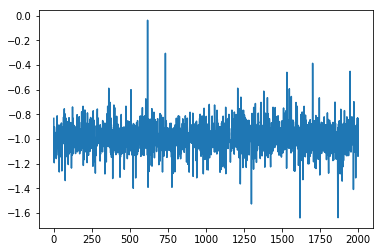

In [71]:
plt.plot(chains['beta'][:,0])

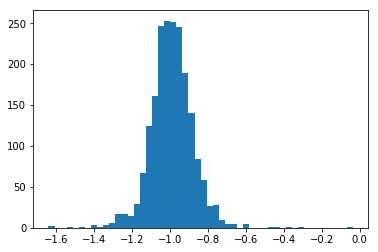

In [72]:
histout = plt.hist(chains['beta'][:,0], bins=50)

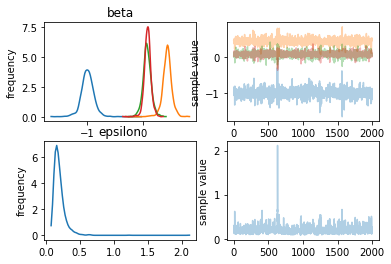

In [74]:
p = lin_fit.plot()

In [ ]:
j